In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import random
from pathlib import Path
import numpy as np
import pytorch_lightning as pl

import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt


import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from sklearn.metrics import precision_recall_fscore_support, mean_absolute_error

from functools import partial

from utils.export_multilingual_results import process_df
from utils.multilingual_amazon_anchors import MultilingualAmazonAnchors
from typing import *

from modules.stitching_module import StitchingModule

from datasets import load_dataset, ClassLabel

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Tensorboard extension (for visualization purposes later)
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = Path("./data")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = Path("./saved_models/rel_multi_vanilla")
RESULT_PATH = Path("./results/rel_multi_vanilla")

PROJECT_ROOT = Path("./")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


# Data

In [2]:
fine_grained: bool = False
target_key: str = "class"
data_key: str = "content"
anchor_dataset_name: str = "amazon_translated"  
ALL_LANGS = ("en", "es", "fr")
num_anchors: int = 768
train_perc: float = 0.25

In [3]:
def get_dataset(lang: str, split: str, perc: float, fine_grained: bool):
    pl.seed_everything(42)
    assert 0 < perc <= 1
    dataset = load_dataset("amazon_reviews_multi", lang)[split]

    if not fine_grained:
        dataset = dataset.filter(lambda sample: sample["stars"] != 3)

    # Select a random subset
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[: int(len(indices) * perc)]
    dataset = dataset.select(indices)

    def clean_sample(sample):
        title: str = sample["review_title"].strip('"').strip(".").strip()
        body: str = sample["review_body"].strip('"').strip(".").strip()

        if body.lower().startswith(title.lower()):
            title = ""

        if len(title) > 0 and title[-1].isalpha():
            title = f"{title}."

        sample["content"] = f"{title} {body}".lstrip(".").strip()
        if fine_grained:
            sample[target_key] = str(sample["stars"] - 1)
        else:
            sample[target_key] = sample["stars"] > 3
        return sample

    dataset = dataset.map(clean_sample)
    dataset = dataset.cast_column(
        target_key,
        ClassLabel(num_classes=5 if fine_grained else 2, names=list(map(str, range(5) if fine_grained else (0, 1)))),
    )

    return dataset

def _amazon_translated_get_samples(lang: str, sample_idxs):
    anchor_dataset = MultilingualAmazonAnchors(split="train", language=lang)
    anchors = []
    for anchor_idx in sample_idxs:
        anchor = anchor_dataset[anchor_idx]
        anchor[data_key] = anchor["data"]
        anchors.append(anchor)
    return anchors

In [6]:
train_datasets = {
    lang: get_dataset(lang=lang, split="train", perc=train_perc, fine_grained=fine_grained) for lang in ALL_LANGS
    }

test_datasets = {
    lang: get_dataset(lang=lang, split="test", perc=1, fine_grained=fine_grained) for lang in ALL_LANGS
    }

val_datasets = {
    lang: get_dataset(lang=lang, split="validation", perc=1, fine_grained=fine_grained) for lang in ALL_LANGS
    }

num_labels = len(np.unique(train_datasets["en"][target_key], return_counts=True)[0])
print("Num labels:", num_labels)

Global seed set to 42
Found cached dataset amazon_reviews_multi (C:/Users/alexg/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-f51cbde5c27a2018.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-eddc29b60b9d78dc.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-cfbda51bc44d995d.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (C:/Users/alexg/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\es\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-e39f9db3ba417a39.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\es\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-1d2c08c5fe8571de.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\es\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-111b13103610f75f.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (C:/Users/alexg/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\fr\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-91f37b238e5daad3.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\fr\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-58e4cd1aa62b8c65.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\fr\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-cfbe68faf49c4454.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (C:/Users/alexg/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-86157cf8aa7adeae.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-cb8732868bfa023d.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-128f376c6a28e8ca.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (C:/Users/alexg/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\es\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-cddb0c4c987e1492.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\es\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-b4f32cb7931fc994.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\es\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-6faf13ff49c1c13e.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (C:/Users/alexg/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\fr\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-a01272ad3c64d584.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\fr\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-a78563a3a41c4c8f.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\fr\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-e24610e9b918204f.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (C:/Users/alexg/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-5b0aceaa1c816ef4.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-daac4dfb1d349f22.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-b6c19866f5e5ed5c.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (C:/Users/alexg/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\es\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-346b78a2849c0016.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\es\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-ce9936bc59eea3f4.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\es\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-2801174435e75a4a.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (C:/Users/alexg/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\fr\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-aa9ebc59268c0b1b.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\fr\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-eb656dd5d8719449.arrow
Loading cached processed dataset at C:\Users\alexg\.cache\huggingface\datasets\amazon_reviews_multi\fr\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609\cache-d2a06c0f1a5ce4fb.arrow


Num labels: 2


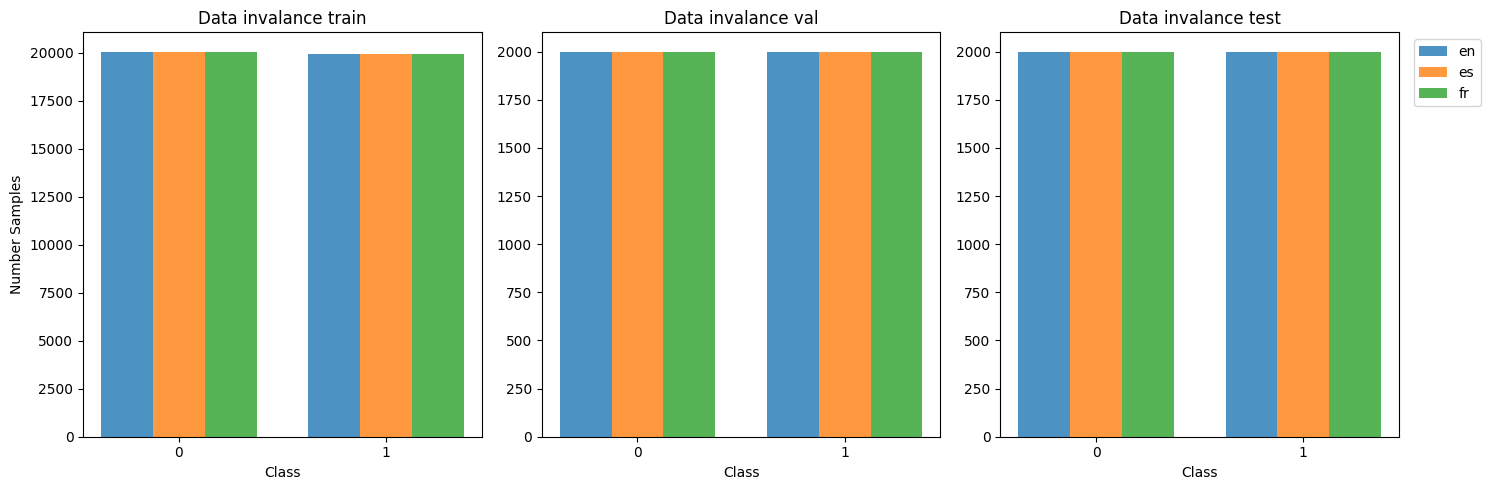

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
index = np.arange(num_labels)
bar_width = 0.25
opacity = 0.8
for i, (name_ds, ds) in enumerate(zip(["train", "val", "test"], [train_datasets, val_datasets, test_datasets])):
    for j, lang in enumerate(ALL_LANGS):
        objects, class_sample_counts=np.unique(ds[lang][target_key], return_counts=True)

        ax[i].bar(index + j*bar_width, class_sample_counts,
                        bar_width,
                        alpha=opacity,
                        label=lang)
        



        ax[i].set_xlabel('Class')
        if name_ds == "train":
            ax[i].set_ylabel('Number Samples')
        ax[i].set_title(f'Data invalance {name_ds}')
        ax[i].set_xticks(index+(len(ALL_LANGS)*bar_width)/2 -bar_width/2, range(num_labels))
        if name_ds == "test":
            ax[i].legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    
plt.tight_layout()
plt.show()

In [7]:
assert len(set(frozenset(train_dataset.features.keys()) for train_dataset in train_datasets.values())) == 1
class2idx = train_datasets["en"].features[target_key].str2int

train_datasets["en"].features

{'review_id': Value(dtype='string', id=None),
 'product_id': Value(dtype='string', id=None),
 'reviewer_id': Value(dtype='string', id=None),
 'stars': Value(dtype='int32', id=None),
 'review_body': Value(dtype='string', id=None),
 'review_title': Value(dtype='string', id=None),
 'language': Value(dtype='string', id=None),
 'product_category': Value(dtype='string', id=None),
 'content': Value(dtype='string', id=None),
 'class': ClassLabel(names=['0', '1', '2', '3', '4'], id=None)}

Get pararel anchors

In [8]:
anchor_dataset2num_samples = 1000
anchor_dataset2first_anchors = [
        776,
        507,
        895,
        922,
        33,
        483,
        85,
        750,
        354,
        523,
        184,
        809,
        418,
        615,
        682,
        501,
        760,
        49,
        732,
        336,
    ]


assert num_anchors <= anchor_dataset2num_samples

pl.seed_everything(42)
anchor_idxs = list(range(anchor_dataset2num_samples))
random.shuffle(anchor_idxs)
anchor_idxs = anchor_idxs[:num_anchors]

assert anchor_idxs[:20] == anchor_dataset2first_anchors  # better safe than sorry
lang2anchors = {
    lang: _amazon_translated_get_samples(lang=lang, sample_idxs=anchor_idxs) for lang in ALL_LANGS
}

Global seed set to 42


This is how we can handdle automatically the tokenizer

In [9]:
def collate_fn(batch, tokenizer, cls=True):
    data = []
    labels = []
    for sample in batch:
        data.append(sample[data_key])
        if cls:
            labels.append(sample[target_key])

    encoding = tokenizer(
        data,
        return_tensors="pt",
        return_special_tokens_mask=True,
        truncation=True,
        max_length=512,
        padding=True,
    )
    del encoding["special_tokens_mask"]

    if cls:
        result = (encoding, torch.tensor(labels))
    else:
        result = encoding

    return  result

# Train

In [10]:
from pl_modules.pl_roberta import LitRelRoberta

In [11]:
lang2transformer_name = {
    "en": "roberta-base",
    "es": "PlanTL-GOB-ES/roberta-base-bne",
    "fr": "ClassCat/roberta-base-french",
    #"ja": "nlp-waseda/roberta-base-japanese",
}
assert set(lang2transformer_name.keys()) == set(ALL_LANGS)

In [12]:
train_lang2dataloader = {}
test_lang2dataloader = {}
val_lang2dataloader = {}
anchors_lang2dataloader = {}

for lang in ALL_LANGS:
    transformer_name = lang2transformer_name[lang]
    print(transformer_name)
    lang_tokenizer = AutoTokenizer.from_pretrained(transformer_name)
    train_lang2dataloader[lang] = DataLoader(train_datasets[lang],
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       shuffle=True,
                                       pin_memory=True,
                                       drop_last=True,
                                       batch_size=16,
                                       )
    
    test_lang2dataloader[lang] = DataLoader(test_datasets[lang],
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       batch_size=32,
                                       )
    
    val_lang2dataloader[lang] = DataLoader(val_datasets[lang],
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       batch_size=32,
                                       )
    
    anchors_lang2dataloader[lang] = DataLoader(lang2anchors[lang],
                                       num_workers=4,
                                       pin_memory=True,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer, cls=False),
                                       batch_size=48,
                                       )

roberta-base
PlanTL-GOB-ES/roberta-base-bne
ClassCat/roberta-base-french


In [13]:
EPOCHS = 5 if fine_grained else 3


def train_network(lang, mode="relative", seed=24, fine_tune=False):
    
    # Create a PyTorch Lightning trainer with the generation callback
    
    if fine_grained:
        title = CHECKPOINT_PATH / 'fine_grained' 
    else:
        title = CHECKPOINT_PATH / 'coarse_grained' 
    
    if fine_tune:
        title = title / f"finetune_{lang}_{mode}_seed{seed}"
    else:
        title = title / f"full_{lang}_{mode}_seed{seed}"
    
    trainer = pl.Trainer(default_root_dir=title, 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         accumulate_grad_batches=num_labels,
                         max_epochs=EPOCHS, 
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    LearningRateMonitor(logging_interval='step')
                                    ])
    
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    transformer_model = lang2transformer_name[lang]
    
    anchor_loader = None
    if mode == "relative":
        anchor_loader = anchors_lang2dataloader[lang]
    
    
    train_loader = train_lang2dataloader[lang]
    
    if fine_tune:
        freq_anchors = len(train_loader)
    else:
        freq_anchors = 100*num_labels
    
    model = LitRelRoberta(num_labels=num_labels,
                          transformer_model=transformer_model,
                          anchor_dataloader=anchor_loader,
                          hidden_size=num_anchors,
                          normalization_mode="batchnorm",
                          output_normalization_mode=None,
                          dropout_prob=0.1,
                          seed=seed,
                          steps=EPOCHS*len(train_loader),
                          weight_decay=0.01, 
                          head_lr=1e-3/num_labels,
                          encoder_lr=1.75e-4/num_labels,
                          layer_decay=0.65,
                          scheduler_act=True,
                          freq_anchors=freq_anchors,
                          device=device,
                          fine_tune=fine_tune
                          )
    
    val_loader = val_lang2dataloader[lang]
    
    trainer.fit(model, train_loader, val_loader)
    
    model.to("cpu")
    del model
    torch.cuda.empty_cache()

    

In [14]:
train_network("en", mode="relative", seed=0, fine_tune=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Missing logger folder: saved_models/rel_multi_vanilla/fine_grain

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [13]:
SEEDS = [1]
TRAIN = False

if TRAIN:
    for seed in tqdm(SEEDS, leave=False, desc="seed"):
        for fine_tune in tqdm([True, False], leave=False, desc="fine_tune"):
            for embedding_type in tqdm(["relative"], leave=False, desc="embedding_type"):
                for train_lang in tqdm(ALL_LANGS, leave=False, desc="lang"):
                    train_network(train_lang, mode=embedding_type, seed=seed, fine_tune=fine_tune)
                    clear_output(wait=True)

# Results

## Compute

In [14]:
def test_model(model, dataloader, title=""):
    preds = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        batch_idx = 0
        for batch, _ in tqdm(dataloader, position=0, leave=True, desc="Computing"+title):
            batch.to(device)
            batch_latents = model(batch_idx=batch_idx, **batch)["prediction"].argmax(-1)
            preds.append(batch_latents)
            batch_idx = 1

    preds = torch.cat(preds, dim=0).detach().cpu().numpy()
    test_y = np.array(test_datasets["en"][target_key])

    precision, recall, fscore, _ = precision_recall_fscore_support(test_y, preds, average="weighted")
    mae = mean_absolute_error(y_true=test_y, y_pred=preds)
    acc = (preds == test_y).mean()
    return precision, recall, acc, fscore, mae

In [15]:
numeric_results = {
    "finetune": {
        "seed": [],
        "embed_type": [],
        "enc_lang": [],
        "dec_lang": [],
        "precision": [],
        "recall": [],
        "acc": [],
        "fscore": [],
        "mae": [],
        "stitched": []
    },
     "full": {
        "seed": [],
        "embed_type": [],
        "enc_lang": [],
        "dec_lang": [],
        "precision": [],
        "recall": [],
        "acc": [],
        "fscore": [],
        "mae": [],
        "stitched": []
    },
}

for seed in [1]:
    models = {
        train_mode: {
            embedding_type: {
                    train_lang: LitRelRoberta.load_from_checkpoint(
                                  CHECKPOINT_PATH / 
                                  f"{'fine_grained' if fine_grained else 'coarse_grained'}/{train_mode}_{train_lang}_{embedding_type}_seed{seed}" /
                                  f"lightning_logs/version_0/checkpoints/{'epoch=4-step=3125.ckpt' if fine_grained else 'epoch=2-step=3750.ckpt'}" )

                    for train_lang in ALL_LANGS
                }
                for embedding_type in ["absolute", "relative"]
        }
        for train_mode in tqdm(["finetune", "full"], leave=True, desc="mode")
    }
    
    for mode in ["finetune", "full"]:
        for embed_type in ["absolute", "relative"]:
            for enc_lang  in ALL_LANGS:
                for dec_lang  in ALL_LANGS:
                    
                    model = models[mode][embed_type][enc_lang].net
                    if embed_type == "relative":
                        model.anchor_dataloader = anchors_lang2dataloader[enc_lang]
                        
                    if enc_lang != dec_lang:
                        model_dec = models[mode][embed_type][dec_lang].net
                        model = StitchingModule(model, model_dec)
                      
                        
                    # The data is paired with its encoder
                    test_loader = test_lang2dataloader[enc_lang]
                    title = f" {mode}_seed{seed}_{embed_type}_{enc_lang}_{dec_lang}"

                    precision, recall, acc, fscore, mae = test_model(model, test_loader, title)
                    numeric_results[mode]["embed_type"].append(embed_type)
                    numeric_results[mode]["enc_lang"].append(enc_lang)
                    numeric_results[mode]["dec_lang"].append(dec_lang)
                    numeric_results[mode]["precision"].append(precision)
                    numeric_results[mode]["recall"].append(recall)
                    numeric_results[mode]["acc"].append(acc)
                    numeric_results[mode]["fscore"].append(fscore)
                    numeric_results[mode]["stitched"].append(enc_lang != dec_lang)
                    numeric_results[mode]["mae"].append(mae)
                    numeric_results[mode]["seed"].append(seed)
    
    for mode in ["finetune", "full"]:
        for embed_type in ["absolute", "relative"]:
            for enc_lang  in ALL_LANGS:
                   del models[mode][embed_type][enc_lang]
                    


mode:   0%|                                                                              | 0/2 [00:00<?, ?it/s]Global seed set to 1
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Global seed set to 1
Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used

Global seed set to 1
Some weights of the model checkpoint at ClassCat/roberta-base-french were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Computing finetune_seed1_absolute_en_es: 100%|███████████████████████████████| 157/157 [00:14<00:00, 10.85it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

In [16]:
for mode in ["finetune", "full"]:
    df = pd.DataFrame(numeric_results[mode])
    
    df_2 = pd.read_csv(
        RESULT_PATH / f"nlp_multilingual-stitching-amazon-{'fine_grained' if fine_grained else 'coarse_grained'}-finetune-{train_perc}.tsv",
        sep='\t')
    
    df = pd.concat([df, df_2])
    
    df.to_csv(
        RESULT_PATH / f"nlp_multilingual-stitching-amazon-{'fine_grained' if fine_grained else 'coarse_grained'}-{mode}-{train_perc}.tsv",
        sep="\t",
        index=False
    )

## View

In [19]:
fine_grained: bool = True

df_fine, tex_fine = process_df(fine_grained=fine_grained, mode="finetune", path=RESULT_PATH)

print(tex_fine)

df_fine

\begin{table}[ht]
\centering
\resizebox{\textwidth}{!}{
\begin{tabular}{clcccccc}
\toprule
   &    & \multicolumn{3}{c}{Absolute} & \multicolumn{3}{c}{Relative} \\
 \cmidrule(lr){3-5} 
 \cmidrule(lr){6-8} 
 Decoder & Encoder & Acc & FScore & MAE & Acc & FScore & MAE \\
\midrule
\multirow{3}{*}{en} & en &  $55.67 \pm 0.58$ &  $54.96 \pm 1.86$ &    $53.80 \pm 2.55$ &  $55.06 \pm 0.82$ &  $54.33 \pm 1.13$ &   $55.69 \pm 2.33$ \\
   & es &  $18.80 \pm 1.61$ &   $8.14 \pm 2.06$ &  $191.49 \pm 12.12$ &  $44.59 \pm 0.16$ &  $42.44 \pm 0.59$ &   $79.93 \pm 0.27$ \\
   & fr &  $21.30 \pm 0.82$ &  $17.04 \pm 3.28$ &   $143.92 \pm 3.71$ &  $41.61 \pm 1.09$ &  $38.86 \pm 0.73$ &   $92.23 \pm 3.69$ \\
&\\
\multirow{3}{*}{es} & en &  $18.64 \pm 1.78$ &   $6.57 \pm 0.11$ &   $207.14 \pm 9.42$ &  $41.63 \pm 1.43$ &  $39.98 \pm 1.35$ &  $101.07 \pm 7.57$ \\
   & es &  $54.18 \pm 0.51$ &  $53.80 \pm 0.50$ &    $54.67 \pm 1.23$ &  $51.46 \pm 0.31$ &  $49.79 \pm 0.27$ &   $61.15 \pm 0.35$ \\
   & fr &  $2

Absolute                                   Relative        \
                     acc       fscore           mae             acc         
                    mean   std   mean   std    mean    std     mean   std   
Decoder Encoder                                                             
en      en         55.67  0.58  54.96  1.86   53.80   2.55    55.06  0.82   
        es         18.80  1.61   8.14  2.06  191.49  12.12    44.59  0.16   
        fr         21.30  0.82  17.04  3.28  143.92   3.71    41.61  1.09   
es      en         18.64  1.78   6.57  0.11  207.14   9.42    41.63  1.43   
        es         54.18  0.51  53.80  0.50   54.67   1.23    51.46  0.31   
        fr         21.01  0.41  12.19  0.45  193.09   2.28    39.88  0.88   
fr      en         20.16  0.23   9.04  3.36  131.96  11.37    43.29  1.94   
        es         20.15  0.27   9.77  0.17  139.57   5.44    40.95  0.13   
        fr         49.12  1.24  48.86  1.00   63.76   0.28    46.39  1.09   

                                            
                fscore           mae        
                  mean   std    mean   std  
Decoder Encoder                             
en      en       54.33  1.13   55.69  2.33  
        es       42.44  0.59   79.93  0.27  
        fr       38.86  0.73   92.23  3.69  
es      en       39.98  1.35  101.07  7.57  
        es       49.79  0.27   61.15  0.35  
        fr       36.33  2.00   99.27  2.98  
fr      en       42.66  1.56   80.38  2.09  
        es       38.51  0.08   92.40  0.99  
        fr       45.26  1.98   74.25  4.17

In [20]:
df_full, tex_full = process_df(fine_grained=fine_grained, mode="full", path=RESULT_PATH)

print(tex_full)
df_full

\begin{table}[ht]
\centering
\resizebox{\textwidth}{!}{
\begin{tabular}{clcccccc}
\toprule
   &    & \multicolumn{3}{c}{Absolute} & \multicolumn{3}{c}{Relative} \\
 \cmidrule(lr){3-5} 
 \cmidrule(lr){6-8} 
 Decoder & Encoder & Acc & FScore & MAE & Acc & FScore & MAE \\
\midrule
\multirow{3}{*}{en} & en &  $59.59 \pm 5.57$ &  $58.83 \pm 5.99$ &    $48.53 \pm 8.17$ &   $58.90 \pm 5.54$ &   $58.30 \pm 5.83$ &   $49.70 \pm 9.06$ \\
   & es &  $19.08 \pm 0.94$ &   $9.83 \pm 3.20$ &   $195.92 \pm 7.32$ &   $50.47 \pm 8.10$ &   $49.01 \pm 8.81$ &  $66.34 \pm 18.70$ \\
   & fr &  $19.06 \pm 2.84$ &  $14.45 \pm 3.12$ &  $158.33 \pm 21.04$ &   $47.13 \pm 7.94$ &   $44.90 \pm 8.51$ &  $76.49 \pm 22.84$ \\
&\\
\multirow{3}{*}{es} & en &  $15.07 \pm 4.44$ &   $8.41 \pm 2.56$ &  $220.66 \pm 16.41$ &  $49.46 \pm 11.22$ &  $47.93 \pm 11.34$ &  $79.84 \pm 31.81$ \\
   & es &  $56.38 \pm 2.86$ &  $56.08 \pm 2.97$ &    $50.43 \pm 5.46$ &   $54.70 \pm 4.54$ &   $53.48 \pm 5.15$ &   $54.86 \pm 8.73$ \\
   

Absolute                                   Relative         \
                     acc       fscore           mae             acc          
                    mean   std   mean   std    mean    std     mean    std   
Decoder Encoder                                                              
en      en         59.59  5.57  58.83  5.99   48.53   8.17    58.90   5.54   
        es         19.08  0.94   9.83  3.20  195.92   7.32    50.47   8.10   
        fr         19.06  2.84  14.45  3.12  158.33  21.04    47.13   7.94   
es      en         15.07  4.44   8.41  2.56  220.66  16.41    49.46  11.22   
        es         56.38  2.86  56.08  2.97   50.43   5.46    54.70   4.54   
        fr         17.73  4.63  10.87  1.97  191.68   1.78    46.35   8.59   
fr      en         21.87  2.27  15.38  7.83  127.80   6.87    52.30  11.77   
        es         14.63  7.48   8.38  1.96  172.78  43.84    48.16   9.84   
        fr         51.79  4.12  51.43  3.87   58.48   7.32    50.35   5.11   

                                             
                fscore           mae         
                  mean    std   mean    std  
Decoder Encoder                              
en      en       58.30   5.83  49.70   9.06  
        es       49.01   8.81  66.34  18.70  
        fr       44.90   8.51  76.49  22.84  
es      en       47.93  11.34  79.84  31.81  
        es       53.48   5.15  54.86   8.73  
        fr       43.63   9.41  79.77  25.79  
fr      en       51.70  11.91  63.85  21.99  
        es       46.55  10.98  73.71  25.28  
        fr       49.32   5.05  64.73  11.94